# Find your best team using Genetic Algorithms

<center><img src="https://img.fifa.com/image/upload/t_l1/hmkwxxkgr5j8rqa8uhmw.jpg"></center>


### Everyone of us played FIFA and knows how it hard sometimes to select your best team. 

### In this code sample it will be presented a basic approach for genetic algorithm to select a team using some constraints like total amount of money and average age of players.

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [4]:
# Read CSV Dataset
df = pd.read_csv('./input/data.csv')
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


Select and prepare columns that we will use.

In [5]:
df = df[['Name', 'Age', 'Overall', 'Value', 'Position']]
df['Value'] = df['Value'].str.replace('€','').str.replace('M',' 1000000').str.replace('K',' 1000')
df['Value'] = df['Value'].str.split(' ', expand=True)[0].astype(float) * df['Value'].str.split(' ', expand=True)[1].astype(float).fillna(0).astype(np.float32)
df = df[df['Position'].notnull()]
df = df[df['Value']>10000]

df.head()

,Name,Age,Overall,Value,Position
0,L. Messi,31,94,110500000.0,RF
1,Cristiano Ronaldo,33,94,77000000.0,ST
2,Neymar Jr,26,92,118500000.0,LW
3,De Gea,27,91,72000000.0,GK
4,K. De Bruyne,27,91,102000000.0,RCM


To simplify task we will use next positions: Center Forward, Left Forward, Right Forward, Center Half, Left Half, Right Half, Center Defender, Left Defender, Right Defender and Goalkeeper.

We will use standard scheme for team (4-3-3: 4 defenders, 3 halfs and 3 forwards) and select 2 teams (main and second). In total we will have 22 players.

In [6]:
replace_dict = {
    'GK': 'Goalkeeper',
    'ST': 'Center Forward', 
    'CF': 'Center Forward',
    'LF': 'Left Forward', 
    'LS': 'Left Forward',
    'RF': 'Right Forward', 
    'RS': 'Right Forward',
    'RCM': 'Center Half', 
    'LCM': 'Center Half', 
    'LDM': 'Center Half', 
    'CAM': 'Center Half', 
    'CDM': 'Center Half', 
    'RDM': 'Center Half', 
    'CM': 'Center Half',
    'LW': 'Left Half', 
    'LAM': 'Left Half', 
    'LM': 'Left Half',
    'RM': 'Right Half', 
    'RW': 'Right Half', 
    'RAM': 'Right Half',
    'RCB': 'Center Defender',
    'CB': 'Center Defender', 
    'LCB': 'Center Defender',
    'LB': 'Left Defender',  
    'LWB': 'Left Defender',
    'RB': 'Right Defender', 
    'RWB': 'Right Defender'
}

df['Position'] = df['Position'].replace(replace_dict)

In [7]:
df['Position'].unique().tolist()

['Right Forward',
 'Center Forward',
 'Left Half',
 'Goalkeeper',
 'Center Half',
 'Left Forward',
 'Center Defender',
 'Right Half',
 'Left Defender',
 'Right Defender']

In [8]:
class Player:
    def __init__(self, name, age, overall, value, position):
        self.name = name
        self.age = age
        self.overall = overall
        self.value = value
        self.position = position

To generate individual we will select 2 unique random players for every position. Only for position Central Defender we will select 4 players, because we need 2 of them on the field at the same time.

In [9]:
def generate_player(player_df, genes, use_best=False):
    gen_df = player_df.sort_values(['Overall'], ascending=False)
    if use_best:
        player = 0
    else:
        player = random.randint(0, len(gen_df)-1)
    player_item = Player(
        gen_df.iloc[player]['Name'], 
        gen_df.iloc[player]['Age'],
        gen_df.iloc[player]['Overall'],
        gen_df.iloc[player]['Value'],
        gen_df.iloc[player]['Position']
    )
    
    return player_item

In [10]:
def create_individual(football_df):
    genes = list()
    positions = [
        'Goalkeeper', 'Left Defender', 'Right Defender', 
        'Center Defender', 'Left Half', 'Right Half', 
        'Center Half', 'Left Forward', 'Right Forward', 'Center Forward'
    ] 
    
    for pos in positions:
        player_df = football_df[football_df['Position'] == pos]
        for i in range(2):
            player_item = generate_player(player_df, genes)
            genes.append(player_item)
        if pos == 'Center Defender':
            for i in range(2):
                player_item = generate_player(player_df, genes)
                genes.append(player_item)

    return genes

Our fitness function is a total power of a team (sum of Overall) minus amount of money that we spent over our limits and minus number of years * 10 over our limit (average age).

In [11]:
def fitness(max_money, avg_age, individual):
    score = cost = age = 0
    for player in individual:
        score += player.overall
        cost += player.value
        age += player.age

    score += min(0, max_money-cost)
    age_diff = (avg_age - age / 22) * 10
    score += min(0, age_diff)
    
    if len(list(set([it.name for it in individual]))) != 22:
        score -= 1000000
        
    return score

To mutate individual we just select new player for current position if random value is less than mutation rate.

In [12]:
def mutate(individual, mutation_rate, mutation_best_rate, footbal_df):
    new = list()
    for gene in individual:
        player_df = footbal_df[footbal_df['Position'] == gene.position]
        if mutation_best_rate > random.random():
            player_item = generate_player(player_df, individual, use_best=True)
            new.append(player_item)
            continue
        if mutation_rate > random.random():
            player_item = generate_player(player_df, individual)
            new.append(player_item)
        else:
            player_item = generate_player(player_df, individual)
            new.append(player_item)
    return new

Let's define constants

In [13]:
MAX_MONEY = 1200000000
AVG_AGE = 25
EPOCHS = 800
CHILDREN = 25
MUTATION_RATE = 0.15
MUTATION_BEST_RATE = 0.1
MUTATION_CHANGE_OVER_EPOCHS = 120
MUTATION_DECREASE = 0.015
INCREASE_IF_NO_IMPROVES = 80
MUTATION_INCREASE = 0.0075
CHILDREN_INCREASE = 2

Now we are going to run our genetic algorithm. On every epoch we create N children from individual and select only 1 best for next epochs.

In [14]:
ind = create_individual(df)
stable_score = 0
best_score = fitness(MAX_MONEY, AVG_AGE, ind)
best_ind = ind
for i in range(EPOCHS):
    improve_flag = False
    if stable_score == INCREASE_IF_NO_IMPROVES:
        stable_score = 0
        print('Mutation rate increased to: ', MUTATION_RATE+MUTATION_INCREASE)
        MUTATION_RATE += MUTATION_INCREASE
        CHILDREN += CHILDREN_INCREASE
    if i % 20 == 0:
        print('Epoch: ', i, best_score)
    if i % MUTATION_CHANGE_OVER_EPOCHS == 0 and i != 0:
        print('Mutation rate decreased to: ', MUTATION_RATE-MUTATION_DECREASE)
        MUTATION_RATE -= MUTATION_DECREASE
    for i in range(CHILDREN):
        child = mutate(ind, MUTATION_RATE, MUTATION_BEST_RATE, df)
        child_score = fitness(MAX_MONEY, AVG_AGE, child)
        if child_score >= best_score:
            best_score = child_score
            best_ind = child
            improve_flag=True
            
    if improve_flag == False:
        stable_score += 1

Epoch:  0 1409
Epoch:  20 1634.1818181818182
Epoch:  40 1634.1818181818182
Epoch:  60 1634.1818181818182
Epoch:  80 1635.6363636363637
Mutation rate increased to:  0.1575
Epoch:  100 1635.6363636363637
Epoch:  120 1635.6363636363637
Mutation rate decreased to:  0.14250000000000002
Epoch:  140 1640.1818181818182
Epoch:  160 1640.1818181818182
Mutation rate increased to:  0.15000000000000002
Epoch:  180 1678.909090909091
Epoch:  200 1678.909090909091
Epoch:  220 1678.909090909091
Epoch:  240 1678.909090909091
Mutation rate decreased to:  0.135
Mutation rate increased to:  0.14250000000000002
Epoch:  260 1678.909090909091
Epoch:  280 1678.909090909091
Epoch:  300 1678.909090909091
Epoch:  320 1678.909090909091
Mutation rate increased to:  0.15000000000000002
Epoch:  340 1678.909090909091
Epoch:  360 1678.909090909091
Mutation rate decreased to:  0.135
Epoch:  380 1678.909090909091
Epoch:  400 1678.909090909091
Mutation rate increased to:  0.14250000000000002
Epoch:  420 1678.909090909091


Finally - it is our best team.

In [15]:
for player in best_ind:
    print(player.name, player.overall)

Marcos Lavín 58
Pau López 82
Marcelo 88
João Pereira 62
C. Lindquist 63
D. Cavaré 69
P. Bochniewicz 66
M. Benatia 86
V. Forren 73
Luiz Gustavo 83
Neymar Jr 92
R. Fraser 77
P. Weihrauch 68
J. Corona 81
K. De Bruyne 91
Sergi Darder 79
F. Amuzu 67
W. Zaha 82
A. Aosman 68
S. Haller 80
Cristiano Ronaldo 94
Welthon 74


In [16]:
def draw_pitch(pitch, line, orientation,view):
    
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if view.lower().startswith("h"):
        fig,ax = plt.subplots(figsize=(20.8, 13.6))
        plt.ylim(98, 210)
        plt.xlim(-2, 138)
    else:
        fig,ax = plt.subplots(figsize=(13.6, 20.8))
        plt.ylim(-2, 210)
        plt.xlim(-2, 138)
    ax.axis('off')

    lx1 = [0, 0, 136, 136, 0]
    ly1 = [0, 208, 208, 0, 0]

    plt.plot(lx1,ly1,color=line,zorder=5)

    lx2 = [27.68, 27.68, 108.32, 108.32] 
    ly2 = [208, 175, 175, 208]
    plt.plot(lx2, ly2, color=line, zorder=5)

    lx3 = [27.68, 27.68, 108.32, 108.32] 
    ly3 = [0, 33, 33, 0]
    plt.plot(lx3,ly3,color=line,zorder=5)

    lx4 = [60.68, 60.68, 75.32, 75.32]
    ly4 = [208, 208.4, 208.4, 208]
    plt.plot(lx4,ly4,color=line,zorder=5)

    lx5 = [60.68,60.68,75.32,75.32]
    ly5 = [0,-0.4,-0.4,0]
    plt.plot(lx5,ly5,color=line,zorder=5)

    lx6 = [49.68,49.68,86.32,86.32]
    ly6 = [208,199,199,208]
    plt.plot(lx6,ly6,color=line,zorder=5)

    lx7 = [49.68,49.68,86.32,86.32]
    ly7 = [0,9,9,0]
    plt.plot(lx7,ly7,color=line,zorder=5)

    lx8 = [0,136] 
    ly8 = [104,104]
    plt.plot(lx8,ly8,color=line,zorder=5)

    plt.scatter(68,186,color=line,zorder=5)
    plt.scatter(68,22,color=line,zorder=5)
    plt.scatter(68,104,color=line,zorder=5)

    circle1 = plt.Circle((68,187), 18.30,ls='solid',lw=3,color=line, fill=False, zorder=1,alpha=1)
    circle2 = plt.Circle((68,21), 18.30,ls='solid',lw=3,color=line, fill=False, zorder=1,alpha=1)
    circle3 = plt.Circle((68,104), 18.30,ls='solid',lw=3,color=line, fill=False, zorder=2,alpha=1)

    rec1 = plt.Rectangle((40, 175), 60,33,ls='-',color=pitch, zorder=1,alpha=1)
    rec2 = plt.Rectangle((40, 0), 60,33,ls='-',color=pitch, zorder=1,alpha=1)
    rec3 = plt.Rectangle((-1, -1), 140,212,ls='-',color=pitch, zorder=1,alpha=1)

    ax.add_artist(rec3)
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(rec1)
    ax.add_artist(rec2)
    ax.add_artist(circle3)   

In [17]:
first_team = []
second_team = []

i = 0
while i < len(best_ind):
    if best_ind[i].overall >= best_ind[i+1].overall:
        first_team.append(best_ind[i])
        second_team.append(best_ind[i+1])
    else:
        first_team.append(best_ind[i+1])
        second_team.append(best_ind[i])
    i+=2
    
first_team.reverse()
second_team.reverse()

Our first team

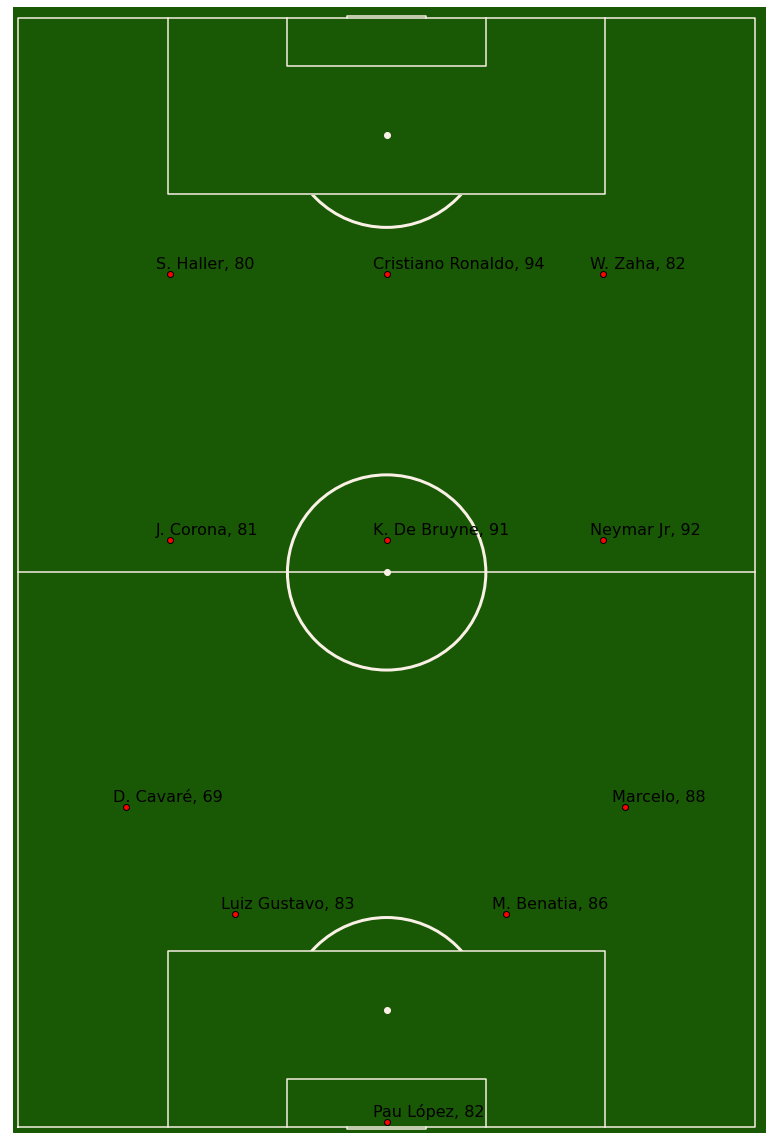

In [18]:
draw_pitch(
    "#195905",
    "#faf0e6",
    "v",
    "full"
)

x = [
    68, 28, 108, 68, 28, 108, 40, 90, 20, 112, 68
]
y = [160, 160, 160, 110, 110, 110, 40, 40, 60, 60, 1]
n = [str(item.name) + ', ' + str(item.overall) for item in first_team]

for i, type in enumerate(n):
    x_c = x[i]
    y_c = y[i]
    plt.scatter(
        x_c, 
        y_c, 
        marker='o', 
        color='red', 
        edgecolors="black", 
        zorder=10
    )
    plt.text(x_c-2.5, y_c+1, type, fontsize=16)


Our second team

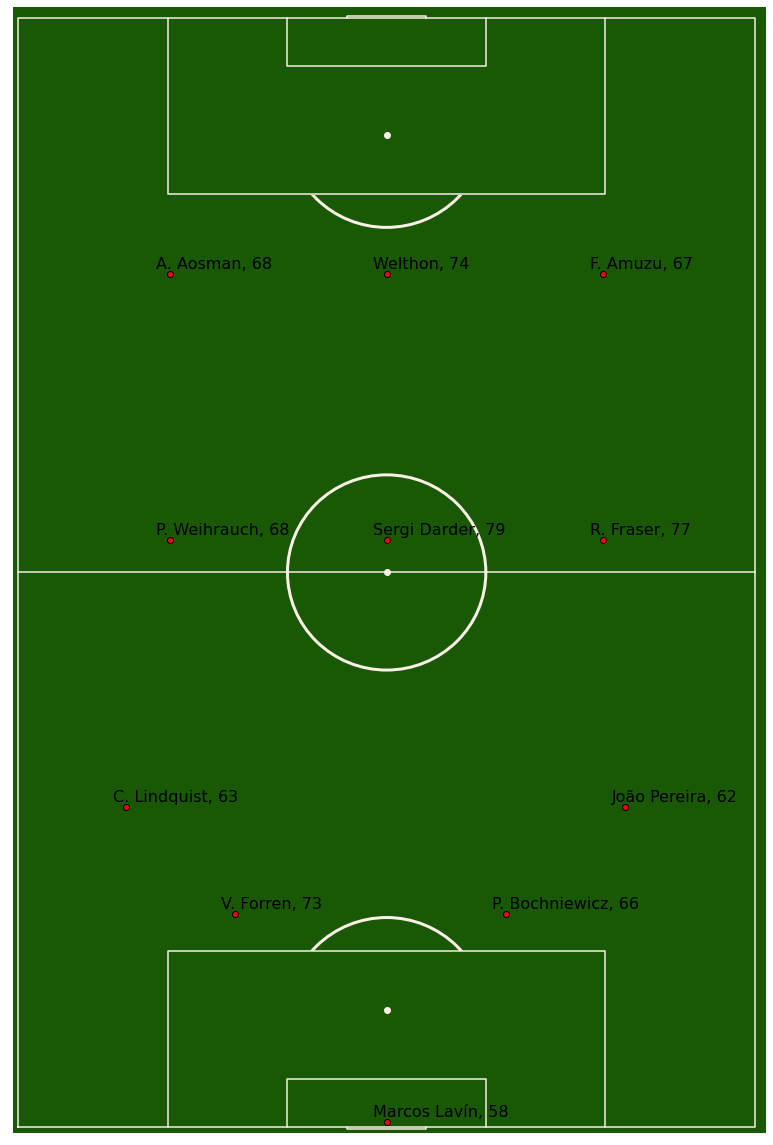

In [19]:
draw_pitch(
    "#195905",
    "#faf0e6",
    "v",
    "full"
)

x = [68, 28, 108, 68, 28, 108, 40, 90, 20, 112, 68]
y = [160, 160, 160, 110, 110, 110, 40, 40, 60, 60, 1]
n = [str(item.name) + ', ' + str(item.overall) for item in second_team]

for i, type in enumerate(n):
    x_c = x[i]
    y_c = y[i]
    plt.scatter(
        x_c, 
        y_c, 
        marker='o', 
        color='red', 
        edgecolors="black", 
        zorder=10
    )
    
    plt.text(
        x_c-2.5, 
        y_c+1, 
        type, 
        fontsize=16
    )